### Deep Convolutional Generative Adversarial Network (DCGAN)  CS 168 Discussion -- Ali Hatamizadeh 


##Import the Dependencies

In [1]:
!pip install imageio
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Import the MNIST Dataset

In [2]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11493376/11490434 [==============================] - 0s 0us/step


#Create the Generator 

In [0]:
def Generator():
    noise_dim = 100
    Input_shape = (noise_dim,)
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False,input_shape=Input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7,7,256)))
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False, activation='tanh'))
  
    return model

#Create the Discriminator 

In [0]:
def Discriminator():
    Input_shape = [28, 28, 1]
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2), padding='same',input_shape=Input_shape))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128,(5,5),strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))


    return model

### Loss functions

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def Loss_Generator(fake):

  loss = cross_entropy(tf.ones_like(fake),fake)

  return loss
    

def Loss_Discriminator(real, fake):

  loss = cross_entropy(tf.ones_like(real),real) + cross_entropy(tf.zeros_like(fake),fake)

  return loss

### Define optimizer and create checkpoints for the model


In [0]:
generator = Generator()
discriminator = Discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

num_examples = 16
noise_dim=100

seed = tf.random.normal([num_examples, noise_dim])

### Create the train steps 

In [0]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = Loss_Generator(fake_output)
      disc_loss = Loss_Discriminator(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


def train(dataset, epochs):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch + 1,seed)

    if (epoch + 1) % 30 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)


def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Train the model 

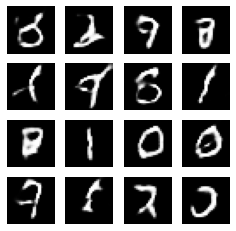

In [16]:
NUM_EPOCHS = 50
train(train_dataset,NUM_EPOCHS) 